# Stats によるローカルレベルの状態空間モデル

statsmodel を用いてローカルレベルの状態空間モデルを構築し、予測値を算出するサンプルコードです。  
※[こちらの記事](https://logics-of-blue.com/python-state-space-models/)を参考にさせていただきました。

## 1. Python Library インポート

In [1]:
# Azure Machine Learning Python SDK のインポート
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import datetime as dt

from matplotlib.pylab import rcParams

# 状態空間モデルのライブラリ
import statsmodels.api as sm

In [3]:
print(azureml.core.VERSION)

1.0.74


### Azure ML ワークスペースへの接続

Azure Machine Learning Workspace への接続情報(config.json) を読み込み、Azure Active Directory の認証で接続します。

In [4]:
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

azureml-mlhack	japaneast	mlhack	japaneast


### 実験の設定

In [5]:
# 実験の名称を設定
experiment=Experiment(ws, "SSM-TEST")

# 実験メトリックの記録開始
run = experiment.start_logging()

## 2. データのインポート

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('../data/AirPassengers.csv',index_col=0, date_parser=dateparse, dtype='float')
data.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


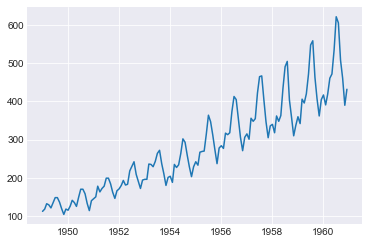

In [7]:
%matplotlib inline
from matplotlib import pylab as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns

plt.plot(data)
plt.savefig("data.png")

In [8]:
# Azure ML へメトリック記録
run.log_image("data", "data.png")

In [9]:
train_df = data[data.index < dt.datetime(1960,1,1)]
test_df = data[data.index >= dt.datetime(1960,1,1)]

train_df.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## 3. ローカルレベルの状態空間モデル推定

In [10]:
# ローカルレベルモデルの推定
#mod_local_level = sm.tsa.UnobservedComponents(data[:-12], 'local level')
mod_local_level = sm.tsa.UnobservedComponents(data[:-12], 'local linear trend')

# 最尤法によるパラメタの推定
res_local_level = mod_local_level.fit(method="bfgs")

# 推定されたパラメタ一覧
print(res_local_level.summary())

Optimization terminated successfully.
         Current function value: 4.944629
         Iterations: 11
         Function evaluations: 24
         Gradient evaluations: 24
                        Unobserved Components Results                         
Dep. Variable:            #Passengers   No. Observations:                  132
Model:             local linear trend   Log Likelihood                -652.691
Date:                Sat, 23 Nov 2019   AIC                           1311.382
Time:                        13:39:08   BIC                           1319.985
Sample:                    01-01-1949   HQIC                          1314.878
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    79.953

/Users/konabuta/miniconda3/envs/myenv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [11]:
# 精度の確認
print(res_local_level.aic)

# Azure ML へメトリック記録
run.log("aic",float(res_local_level.aic))

1311.382131710824


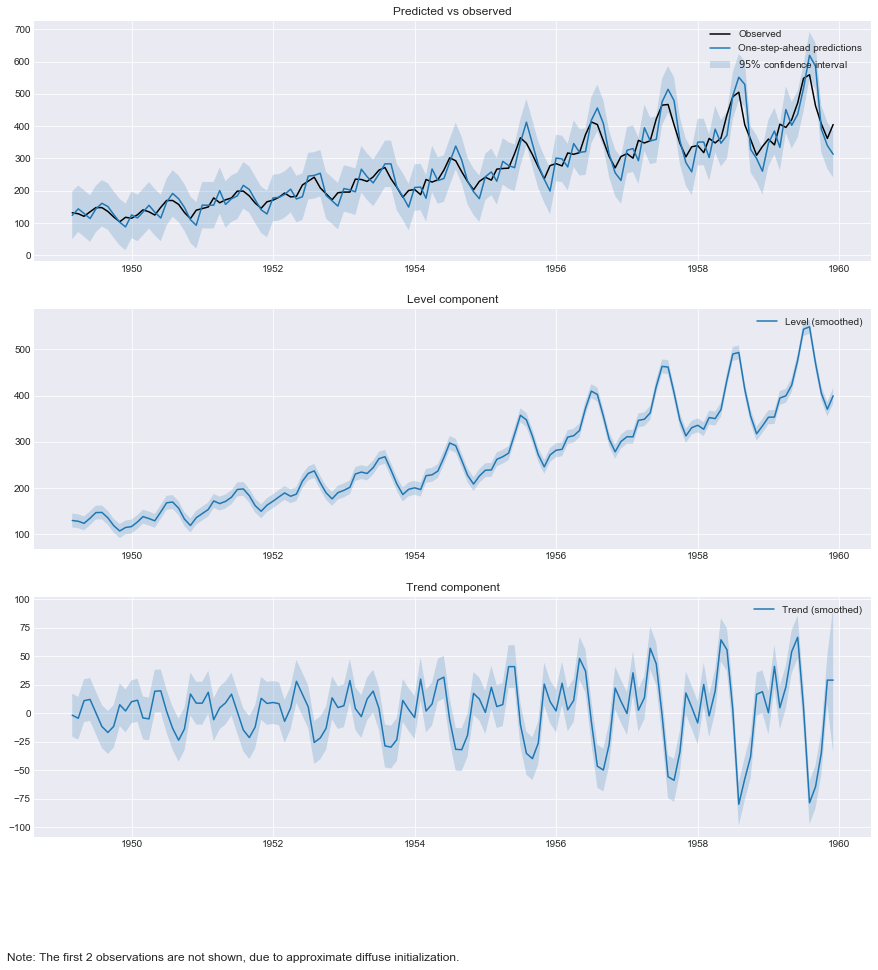

In [12]:
# 推定された状態・トレンドの描画
rcParams['figure.figsize'] = 15, 15
fig = res_local_level.plot_components()
fig.savefig("estimated.png")

In [13]:
# Azure ML へメトリック記録
run.log_image("estimated","estimated.png")

In [14]:
# 予測
y_pred = res_local_level.predict('1960-01-01', '1960-12-01')

# 実測値
y_true = test_df["#Passengers"]

from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_true, y_pred))

# Azure ML へメトリック記録
run.log("mse",mean_squared_error(y_true, y_pred))

25473.94278314803


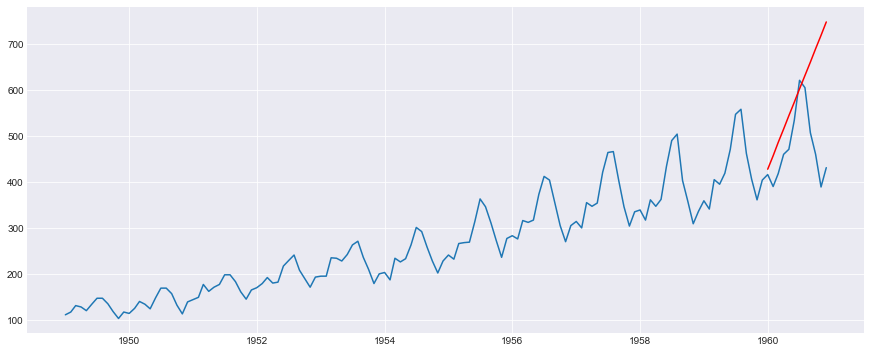

In [15]:
# 実データと予測結果の図示
rcParams['figure.figsize'] = 15, 6

plt.clf()
plt.plot(data)
plt.plot(y_pred, "r")
plt.savefig("predicted.png")

In [16]:
# Azure ML へメトリック記録
run.log_image("predicted","predicted.png")

## 4. モデル登録

In [17]:
model_file_name = "test.pkl"

In [18]:
#from sklearn.externals import joblib
import joblib

with open(model_file_name, "wb") as file:
    joblib.dump(value=res_local_level, filename='outputs/' + model_file_name)

In [19]:
# Azure ML へのモデルファイルのアップロードと共有
run.upload_file("test.pkl", "./outputs/test.pkl")

In [20]:
# Azure ML Workspace へモデル登録
model = run.register_model(model_name='ssm-test', model_path='test.pkl')
print(model.name, model.id, model.version, sep='\t')

ssm-test	ssm-test:2	2


In [21]:
# 実験の詳細ログ  (Git情報などを確認)
run.get_details()

{'runId': 'bbd67255-1b48-4dce-92a5-0e20ec240f98',
 'target': 'sdk',
 'status': 'Running',
 'startTimeUtc': '2019-11-23T04:39:01.855881Z',
 'properties': {'azureml.git.repository_uri': 'https://github.com/konabuta/MLHack-IoT.git',
  'mlflow.source.git.repoURL': 'https://github.com/konabuta/MLHack-IoT.git',
  'azureml.git.branch': 'dev',
  'mlflow.source.git.branch': 'dev',
  'azureml.git.commit': '8e34dda62af95ccad2ad875f7482f937de8ca2af',
  'mlflow.source.git.commit': '8e34dda62af95ccad2ad875f7482f937de8ca2af',
  'azureml.git.dirty': 'True',
  'ContentSnapshotId': 'd11a00c4-2f92-43f2-b6f3-30d4ac878382'},
 'inputDatasets': [],
 'logFiles': {}}

In [22]:
# 実験完了
run.complete()
run

Experiment,Id,Type,Status,Details Page,Docs Page
SSM-TEST,bbd67255-1b48-4dce-92a5-0e20ec240f98,,Running,Link to Azure Machine Learning studio,Link to Documentation


Azure Machine Learning studio から実験のログやメトリックを確認します。